Step 1.2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set project paths
import os
PROJECT_PATH = '/content/drive/MyDrive/UFC_ML_Project'
DATA_RAW = f'{PROJECT_PATH}/data/raw'
DATA_PROCESSED = f'{PROJECT_PATH}/data/processed'
MODELS_PATH = f'{PROJECT_PATH}/models'
VIZ_PATH = f'{PROJECT_PATH}/visualizations'

print("✅ Drive mounted successfully!")
print(f"📁 Project path: {PROJECT_PATH}")

# Install kaleido for image export
!pip install -U kaleido

Mounted at /content/drive
✅ Drive mounted successfully!
📁 Project path: /content/drive/MyDrive/UFC_ML_Project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00


Step 1.3

In [2]:
# Install required packages (excluding kaleido, as it's installed earlier)
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly

# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries installed and imported!")

✅ All libraries installed and imported!


Step 1.4

In [3]:
# Load all datasets
print("📊 Loading datasets...")

data = pd.read_csv(f'{DATA_RAW}/data.csv')
preprocessed = pd.read_csv(f'{DATA_RAW}/preprocessed_data.csv')
fighter_details = pd.read_csv(f'{DATA_RAW}/raw_fighter_details.csv')
fight_data = pd.read_csv(f'{DATA_RAW}/raw_total_fight_data.csv', sep=';')

print(f"✅ data.csv: {data.shape[0]} rows, {data.shape[1]} columns")
print(f"✅ preprocessed_data.csv: {preprocessed.shape[0]} rows, {preprocessed.shape[1]} columns")
print(f"✅ raw_fighter_details.csv: {fighter_details.shape[0]} rows, {fighter_details.shape[1]} columns")
print(f"✅ raw_total_fight_data.csv: {fight_data.shape[0]} rows, {fight_data.shape[1]} columns")

# Display first few rows
print("\n" + "="*80)
print("SAMPLE FROM data.csv:")
print("="*80)
display(data.head(3))

print("\n" + "="*80)
print("SAMPLE FROM raw_fighter_details.csv:")
print("="*80)
display(fighter_details.head(3))

📊 Loading datasets...
✅ data.csv: 6012 rows, 144 columns
✅ preprocessed_data.csv: 5902 rows, 160 columns
✅ raw_fighter_details.csv: 3596 rows, 14 columns
✅ raw_total_fight_data.csv: 6012 rows, 41 columns

SAMPLE FROM data.csv:


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.0,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.5,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0



SAMPLE FROM raw_fighter_details.csv:


,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,NaN,155 lbs.,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Papy Abedi,"5' 11""",185 lbs.,NaN,Southpaw,"Jun 30, 1978",2.80,55%,3.15,48%,3.47,57%,50%,1.3
2,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2


Step 1.5A

In [5]:
# ⚠️ CRITICAL FIX: Filter to modern UFC era (2010+)
print("🗓️ Filtering for modern UFC era...")
data['date'] = pd.to_datetime(data['date'])
original_count = len(data)
data = data[data['date'] >= '2010-01-01'].copy()
print(f"✅ Filtered from {original_count} to {len(data)} modern fights (2010-2021)")
print(f"   Removed {original_count - len(data)} pre-2010 fights")

🗓️ Filtering for modern UFC era...
✅ Filtered from 6012 to 4768 modern fights (2010-2021)
   Removed 1244 pre-2010 fights


Step 1.5B

In [6]:
# Clean and prepare data for ELO calculation
print("🧹 Cleaning data...")

# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort by date (important for ELO calculation)
data = data.sort_values('date').reset_index(drop=True)

# Handle missing values
print(f"\n📊 Missing values before cleaning:")
print(data.isnull().sum()[data.isnull().sum() > 0])

# Fill missing physical attributes with median values by weight class
for col in ['B_Height_cms', 'B_Reach_cms', 'B_Weight_lbs', 'B_age',
            'R_Height_cms', 'R_Reach_cms', 'R_Weight_lbs', 'R_age']:
    if col in data.columns:
        data[col] = data.groupby('weight_class')[col].transform(
            lambda x: x.fillna(x.median())
        )

# Fill missing performance stats with 0 (indicates no data/first fight)
performance_cols = [col for col in data.columns if 'avg_' in col]
data[performance_cols] = data[performance_cols].fillna(0)

# Remove rows with missing winner information
data = data.dropna(subset=['Winner'])

print(f"\n✅ Cleaned data: {data.shape[0]} fights remaining")
print(f"📅 Date range: {data['date'].min()} to {data['date'].max()}")

# Save cleaned data
data.to_csv(f'{DATA_PROCESSED}/cleaned_data.csv', index=False)
print(f"✅ Saved cleaned data to {DATA_PROCESSED}/cleaned_data.csv")

🧹 Cleaning data...

📊 Missing values before cleaning:
Referee                    31
B_avg_KD                 1013
B_avg_opp_KD             1013
B_avg_SIG_STR_pct        1013
B_avg_opp_SIG_STR_pct    1013
                         ... 
R_Stance                   22
R_Height_cms                1
R_Reach_cms               132
B_age                       7
R_age                       1
Length: 107, dtype: int64

✅ Cleaned data: 4768 fights remaining
📅 Date range: 2010-01-02 00:00:00 to 2021-03-20 00:00:00
✅ Saved cleaned data to /content/drive/MyDrive/UFC_ML_Project/data/processed/cleaned_data.csv


Step 1.6

In [10]:
# IMPROVED ELO Rating System Implementation
print("🎯 Implementing IMPROVED ELO Rating System...")

class ImprovedELOSystem:
       def __init__(self, initial_rating=1500):
           self.initial_rating = initial_rating
           self.ratings = {}
           self.weight_class_ratings = {}
           self.fight_counts = {}

       def get_k_factor(self, fighter):
           """Dynamic K-factor based on experience"""
           fights = self.fight_counts.get(fighter, 0)
           if fights < 5:
               return 40
           elif fights < 15:
               return 24
           else:
               return 16

       def get_rating(self, fighter, weight_class=None, rating_type='overall'):
           if rating_type == 'overall':
               return self.ratings.get(fighter, self.initial_rating)
           else:
               if fighter not in self.weight_class_ratings:
                   self.weight_class_ratings[fighter] = {}
               return self.weight_class_ratings[fighter].get(weight_class, self.initial_rating)

       def expected_score(self, rating_a, rating_b):
           return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

       def get_margin_multiplier(self, finish_type):
           """Decisive finishes get higher weight"""
           if pd.isna(finish_type):
               return 1.0
           finish_str = str(finish_type).upper()
           if 'KO' in finish_str or 'TKO' in finish_str or 'SUBMISSION' in finish_str:
               return 1.5
           return 1.0

       def update_ratings(self, winner, loser, weight_class, finish_type=None):
           # Get ratings
           winner_rating = self.get_rating(winner, weight_class, 'overall')
           loser_rating = self.get_rating(loser, weight_class, 'overall')
           winner_wc_rating = self.get_rating(winner, weight_class, 'weight_class')
           loser_wc_rating = self.get_rating(loser, weight_class, 'weight_class')

           # Get K-factors
           k_winner = self.get_k_factor(winner)
           k_loser = self.get_k_factor(loser)

           # Get margin multiplier
           margin = self.get_margin_multiplier(finish_type)

           # Calculate expected scores
           winner_expected = self.expected_score(winner_rating, loser_rating)
           loser_expected = 1 - winner_expected
           winner_wc_expected = self.expected_score(winner_wc_rating, loser_wc_rating)
           loser_wc_expected = 1 - winner_wc_expected

           # Update overall ratings
           new_winner_rating = winner_rating + k_winner * margin * (1 - winner_expected)
           new_loser_rating = loser_rating + k_loser * margin * (0 - loser_expected)

           # Update weight class ratings
           new_winner_wc_rating = winner_wc_rating + k_winner * margin * (1 - winner_wc_expected)
           new_loser_wc_rating = loser_wc_rating + k_loser * margin * (0 - loser_wc_expected)

           # Store ratings
           self.ratings[winner] = new_winner_rating
           self.ratings[loser] = new_loser_rating

           if winner not in self.weight_class_ratings:
               self.weight_class_ratings[winner] = {}
           if loser not in self.weight_class_ratings:
               self.weight_class_ratings[loser] = {}

           self.weight_class_ratings[winner][weight_class] = new_winner_wc_rating
           self.weight_class_ratings[loser][weight_class] = new_loser_wc_rating

           # Update fight counts
           self.fight_counts[winner] = self.fight_counts.get(winner, 0) + 1
           self.fight_counts[loser] = self.fight_counts.get(loser, 0) + 1

           return {
               'winner_rating': new_winner_rating,
               'loser_rating': new_loser_rating,
               'winner_wc_rating': new_winner_wc_rating,
               'loser_wc_rating': new_loser_wc_rating
           }

   # Initialize improved ELO system
elo = ImprovedELOSystem(initial_rating=1500)
print("✅ Improved ELO System initialized!")

🎯 Implementing IMPROVED ELO Rating System...
✅ Improved ELO System initialized!


Step 1.7

In [15]:
# Calculate ELO ratings for all fights chronologically
print("⚙️ Calculating ELO ratings for all fights...")

# Initialize columns
data['R_elo_before'] = 0.0
data['B_elo_before'] = 0.0
data['R_elo_after'] = 0.0
data['B_elo_after'] = 0.0
data['R_elo_wc_before'] = 0.0
data['B_elo_wc_before'] = 0.0
data['R_elo_wc_after'] = 0.0
data['B_elo_wc_after'] = 0.0

# Track statistics
updates_count = 0
skipped_count = 0
red_wins = 0
blue_wins = 0

# Process each fight chronologically
for idx in range(len(data)):
    r_fighter = data.loc[idx, 'R_fighter']
    b_fighter = data.loc[idx, 'B_fighter']
    weight_class = data.loc[idx, 'weight_class']
    winner = data.loc[idx, 'Winner']

    # Get ratings BEFORE fight
    r_elo_overall = elo.get_rating(r_fighter, weight_class, 'overall')
    b_elo_overall = elo.get_rating(b_fighter, weight_class, 'overall')
    r_elo_wc = elo.get_rating(r_fighter, weight_class, 'weight_class')
    b_elo_wc = elo.get_rating(b_fighter, weight_class, 'weight_class')

    data.loc[idx, 'R_elo_before'] = r_elo_overall
    data.loc[idx, 'B_elo_before'] = b_elo_overall
    data.loc[idx, 'R_elo_wc_before'] = r_elo_wc
    data.loc[idx, 'B_elo_wc_before'] = b_elo_wc

    # Determine winner and loser
    if winner == 'Red':
        winner_name = r_fighter
        loser_name = b_fighter
        red_wins += 1
    elif winner == 'Blue':
        winner_name = b_fighter
        loser_name = r_fighter
        blue_wins += 1
    elif winner == 'Draw':
        skipped_count += 1
        # For draws, keep the same ELO
        data.loc[idx, 'R_elo_after'] = r_elo_overall
        data.loc[idx, 'B_elo_after'] = b_elo_overall
        data.loc[idx, 'R_elo_wc_after'] = r_elo_wc
        data.loc[idx, 'B_elo_wc_after'] = b_elo_wc
        continue
    else:
        print(f"⚠️  Row {idx}: Unknown winner: '{winner}'")
        skipped_count += 1
        continue

    # Get finish type (if available)
    finish_type = None
    if 'finish' in data.columns:
        finish_type = data.loc[idx, 'finish']
    elif 'finish_details' in data.columns:
        finish_type = data.loc[idx, 'finish_details']
    elif 'win_by' in data.columns:
        finish_type = data.loc[idx, 'win_by']

    # Update ratings
    new_ratings = elo.update_ratings(winner_name, loser_name, weight_class, finish_type)
    updates_count += 1

    # Store ratings AFTER fight
    data.loc[idx, 'R_elo_after'] = elo.get_rating(r_fighter, weight_class, 'overall')
    data.loc[idx, 'B_elo_after'] = elo.get_rating(b_fighter, weight_class, 'overall')
    data.loc[idx, 'R_elo_wc_after'] = elo.get_rating(r_fighter, weight_class, 'weight_class')
    data.loc[idx, 'B_elo_wc_after'] = elo.get_rating(b_fighter, weight_class, 'weight_class')

    # Progress indicator
    if (idx + 1) % 500 == 0:
        print(f"   Processed {idx + 1}/{len(data)} fights...")

print(f"\n✅ ELO calculation complete for {len(data)} fights!")
print(f"   ✅ Updated: {updates_count}")
print(f"   ⚠️  Skipped (draws): {skipped_count}")
print(f"   Red wins: {red_wins}")
print(f"   Blue wins: {blue_wins}")

# CRITICAL: Verify ELO spread
print(f"\n📊 ELO Rating Verification:")
all_elos = list(elo.ratings.values())
print(f"   Total fighters tracked: {len(all_elos)}")
print(f"   Min ELO: {min(all_elos):.0f}")
print(f"   Max ELO: {max(all_elos):.0f}")
print(f"   Mean ELO: {np.mean(all_elos):.0f}")
print(f"   Std Dev: {np.std(all_elos):.0f}")

# Check if ELO actually changed
elo_spread = max(all_elos) - min(all_elos)
if elo_spread < 100:
    print(f"\n🚨 WARNING: ELO spread is only {elo_spread:.0f} points!")
    print("   This suggests ELO updates aren't working properly.")
    print("   Expected spread: 400-600 points")
else:
    print(f"\n✅ ELO spread looks good: {elo_spread:.0f} points")

# Display sample with ELO changes
print("\n" + "="*80)
print("SAMPLE FIGHTS WITH ELO RATINGS:")
print("="*80)
sample_cols = ['date', 'R_fighter', 'B_fighter', 'Winner', 'weight_class',
               'R_elo_before', 'B_elo_before', 'R_elo_after', 'B_elo_after']
sample = data[sample_cols].tail(20)
display(sample)

# Show ELO changes for recent fights
print("\n📊 Recent ELO Changes:")
recent = data.tail(20).copy()
recent['R_elo_change'] = recent['R_elo_after'] - recent['R_elo_before']
recent['B_elo_change'] = recent['B_elo_after'] - recent['B_elo_before']
print(recent[['R_fighter', 'B_fighter', 'Winner', 'R_elo_change', 'B_elo_change']])

# Check ELO difference distribution
data['elo_diff'] = data['R_elo_before'] - data['B_elo_before']
print(f"\n📊 ELO Difference Statistics:")
print(f"   Mean: {data['elo_diff'].mean():.2f}")
print(f"   Std Dev: {data['elo_diff'].std():.2f}")
print(f"   Min: {data['elo_diff'].min():.2f}")
print(f"   Max: {data['elo_diff'].max():.2f}")

if data['elo_diff'].std() < 10:
    print("\n🚨 WARNING: ELO differences are too small!")
    print("   Most fights have near-identical ELO ratings.")
else:
    print("\n✅ ELO differences look reasonable")

# Save data with ELO ratings
data.to_csv(f'{DATA_PROCESSED}/elo_ratings.csv', index=False)
print(f"\n✅ Saved ELO data to {DATA_PROCESSED}/elo_ratings.csv")

⚙️ Calculating ELO ratings for all fights...
   Processed 500/4768 fights...
   Processed 1000/4768 fights...
   Processed 1500/4768 fights...
   Processed 2000/4768 fights...
   Processed 2500/4768 fights...
   Processed 3000/4768 fights...
   Processed 3500/4768 fights...
   Processed 4000/4768 fights...
   Processed 4500/4768 fights...

✅ ELO calculation complete for 4768 fights!
   ✅ Updated: 4673
   ⚠️  Skipped (draws): 95
   Red wins: 2750
   Blue wins: 1923

📊 ELO Rating Verification:
   Total fighters tracked: 1673
   Min ELO: 1411
   Max ELO: 1700
   Mean ELO: 1500
   Std Dev: 42

✅ ELO spread looks good: 288 points

SAMPLE FIGHTS WITH ELO RATINGS:


,date,R_fighter,B_fighter,Winner,weight_class,R_elo_before,B_elo_before,R_elo_after,B_elo_after
4748,2021-03-13,Charles Jourdain,Marcelo Rojo,Red,Featherweight,1484.530377,1500.000000,1505.420292,1479.110085
4749,2021-03-13,Angela Hill,Ashley Yoder,Red,WomenStrawweight,1485.205387,1475.994619,1492.993351,1464.312674
4750,2021-03-13,Eryk Anders,Darren Stewart,Draw,Middleweight,1510.112834,1503.927484,1510.112834,1503.927484
4751,2021-03-13,Dan Ige,Gavin Tucker,Red,Featherweight,1571.852921,1558.250560,1583.383352,1546.720129
4752,2021-03-13,Nasrat Haqparast,Rafa Garcia,Red,Lightweight,1528.895814,1500.000000,1539.900083,1481.659552
4753,2021-03-13,Cortney Casey,JJ Aldrich,Blue,WomenFlyweight,1477.804148,1518.394531,1467.199746,1528.998933
4754,2021-03-13,Matthew Semelsberger,Jason Witt,Red,Welterweight,1520.000000,1500.330551,1538.868944,1481.461607
4755,2021-03-13,Rani Yahya,Ray Rodriguez,Red,Bantamweight,1578.771503,1481.609640,1584.590822,1467.061342
4756,2021-03-13,Gloria de Paula,Jinh Yu Frey,Blue,WomenStrawweight,1500.000000,1461.094919,1477.769757,1483.325162
4757,2021-03-13,Jonathan Martinez,Davey Grant,Blue,Bantamweight,1532.076601,1496.047114,1518.836628,1509.287087



📊 Recent ELO Changes:
                 R_fighter          B_fighter Winner  R_elo_change  \
4748      Charles Jourdain       Marcelo Rojo    Red     20.889915   
4749           Angela Hill       Ashley Yoder    Red      7.787964   
4750           Eryk Anders     Darren Stewart   Draw      0.000000   
4751               Dan Ige       Gavin Tucker    Red     11.530431   
4752      Nasrat Haqparast        Rafa Garcia    Red     11.004269   
4753         Cortney Casey         JJ Aldrich   Blue    -10.604402   
4754  Matthew Semelsberger         Jason Witt    Red     18.868944   
4755            Rani Yahya      Ray Rodriguez    Red      5.819319   
4756       Gloria de Paula       Jinh Yu Frey   Blue    -22.230243   
4757     Jonathan Martinez        Davey Grant   Blue    -13.239973   
4758          Trevin Giles      Roman Dolidze    Red     12.073097   
4759           Tai Tuivasa    Harry Hunsucker    Red     11.414526   
4760         Cheyanne Buys  Montserrat Conejo   Blue    -20.000000 

Step 1.8

In [16]:
# Visualization 1: ELO Progression Over Time for Top Fighters
print("📊 Creating ELO progression visualization...")

# Get top fighters by final ELO rating
top_fighters = []
for fighter, rating in elo.ratings.items():
    top_fighters.append({'fighter': fighter, 'final_elo': rating})

top_fighters_df = pd.DataFrame(top_fighters).sort_values('final_elo', ascending=False).head(10)

print("\n🏆 TOP 10 FIGHTERS BY ELO:")
print(top_fighters_df.to_string(index=False))

# Create ELO progression plot for top 5 fighters
fig = go.Figure()

for fighter in top_fighters_df['fighter'].head(5):
    fighter_history = data[(data['R_fighter'] == fighter) | (data['B_fighter'] == fighter)].copy()

    elo_progression = []
    dates = []

    for idx, fight in fighter_history.iterrows():
        if fight['R_fighter'] == fighter:
            dates.append(fight['date'])
            elo_progression.append(fight['R_elo_after'])
        else:
            dates.append(fight['date'])
            elo_progression.append(fight['B_elo_after'])

    fig.add_trace(go.Scatter(
        x=dates,
        y=elo_progression,
        mode='lines+markers',
        name=fighter,
        line=dict(width=2),
        marker=dict(size=6)
    ))

fig.update_layout(
    title='ELO Progression Over Time - Top 5 Fighters',
    xaxis_title='Date',
    yaxis_title='ELO Rating',
    hovermode='x unified',
    height=600,
    width=1000,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Save HTML (always works)
fig.write_html(f'{VIZ_PATH}/elo_progression.html')

# Try to save PNG, with graceful fallback
try:
    fig.write_image(f'{VIZ_PATH}/elo_progression.png', width=1200, height=600)
    print(f"✅ Saved ELO progression chart to {VIZ_PATH}/elo_progression.png")
except (ValueError, ImportError) as e:
    print(f"⚠️  PNG export skipped (kaleido not installed)")
    print(f"💡 Tip: Install kaleido with: !pip install -U kaleido")

print(f"✅ Saved interactive chart to {VIZ_PATH}/elo_progression.html")

# Display in notebook
fig.show()

📊 Creating ELO progression visualization...

🏆 TOP 10 FIGHTERS BY ELO:
              fighter   final_elo
            Jon Jones 1699.571600
         Kamaru Usman 1681.870879
  Khabib Nurmagomedov 1677.006392
   Demetrious Johnson 1656.251909
         Amanda Nunes 1655.904816
        Tony Ferguson 1646.249784
Alexander Volkanovski 1645.390745
       Dustin Poirier 1644.902988
         Stipe Miocic 1638.506038
      Israel Adesanya 1634.441690
⚠️  PNG export skipped (kaleido not installed)
💡 Tip: Install kaleido with: !pip install -U kaleido
✅ Saved interactive chart to /content/drive/MyDrive/UFC_ML_Project/visualizations/elo_progression.html


Step 1.9

📊 Analyzing ELO distribution...
✅ Saved ELO distribution chart to /content/drive/MyDrive/UFC_ML_Project/visualizations/elo_distribution.png


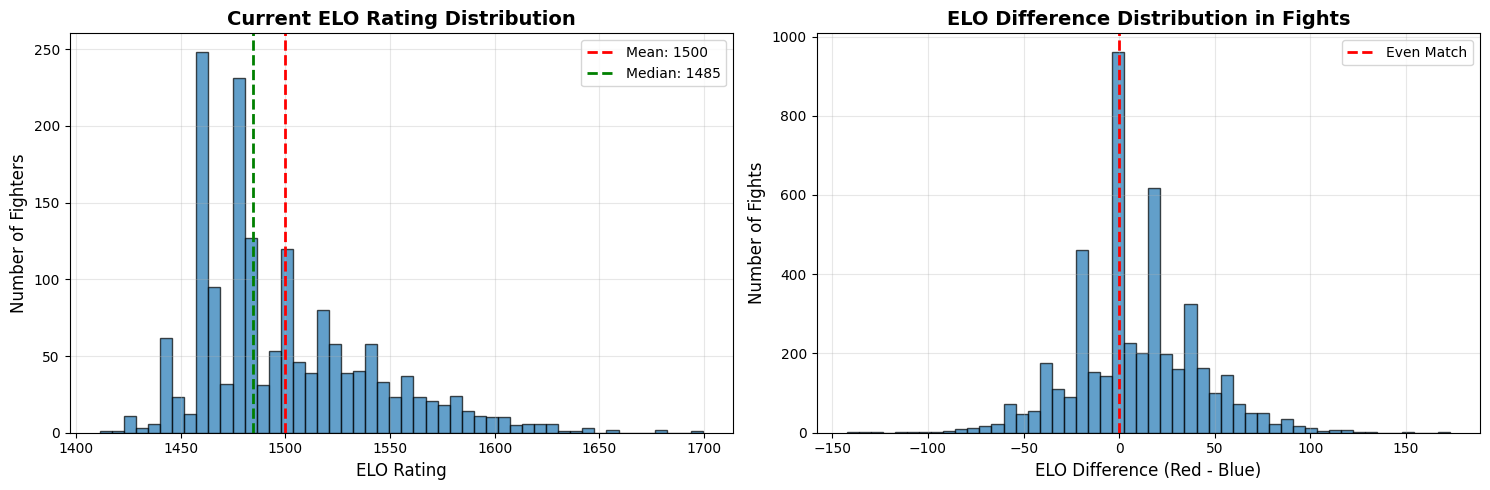


ELO RATING STATISTICS:
Total fighters tracked: 1673
Mean ELO: 1499.92
Median ELO: 1484.73
Std Dev: 42.41
Min ELO: 1411.29
Max ELO: 1699.57


In [17]:
# Distribution of ELO ratings
print("📊 Analyzing ELO distribution...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall ELO distribution
current_elos = list(elo.ratings.values())
axes[0].hist(current_elos, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(current_elos), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(current_elos):.0f}')
axes[0].axvline(np.median(current_elos), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(current_elos):.0f}')
axes[0].set_xlabel('ELO Rating', fontsize=12)
axes[0].set_ylabel('Number of Fighters', fontsize=12)
axes[0].set_title('Current ELO Rating Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ELO difference in fights
data['elo_diff'] = data['R_elo_before'] - data['B_elo_before']
axes[1].hist(data['elo_diff'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Even Match')
axes[1].set_xlabel('ELO Difference (Red - Blue)', fontsize=12)
axes[1].set_ylabel('Number of Fights', fontsize=12)
axes[1].set_title('ELO Difference Distribution in Fights', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/elo_distribution.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved ELO distribution chart to {VIZ_PATH}/elo_distribution.png")
plt.show()

# Summary statistics
print("\n" + "="*80)
print("ELO RATING STATISTICS:")
print("="*80)
print(f"Total fighters tracked: {len(elo.ratings)}")
print(f"Mean ELO: {np.mean(current_elos):.2f}")
print(f"Median ELO: {np.median(current_elos):.2f}")
print(f"Std Dev: {np.std(current_elos):.2f}")
print(f"Min ELO: {np.min(current_elos):.2f}")
print(f"Max ELO: {np.max(current_elos):.2f}")